## What to focus on changing based on meeting
-new_weights: MDS weight matrix (in cell 4), focus on changing values but could potentially change structure too

-grouping: added distance to force region separation (cell 5), increase values to increase separation

-x: can switch to continuous or continue using discrete x (np.load in cell 3)

-can also change the random seed as the algorithm is sometimes unstable

### Less important possible changes
-sim_to_dist: similarity to distance measure may not be perfect

-potentially add region weighting idea within the cluster weighting of new_weights

In [1]:
from mds_temp import MDS

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
#from sklearn.manifold import MDS

def count_cells():
    # Counting the number of cells in the anterior, middle and posterior regions for comparison
    a = np.where(load_region() == 1, np.ones_like(load_region()), np.zeros_like(load_region())).sum()  # anterior
    m = np.where(load_region() == 2, np.ones_like(load_region()), np.zeros_like(load_region())).sum()  # middle
    p = np.where(load_region() == 3, np.ones_like(load_region()), np.zeros_like(load_region())).sum()  # posterior

    ap_m = a * m + p * m  # pairwise connections: anterior + posterior to middle
    a_p = a * p  # pairwise connections: anterior to posterior
    print(ap_m)  # = 542,956
    print(a_p)  # = 805,272
    print(a_p - ap_m)  # = 262,316

def sim_to_dist(x, max):
    # convert similarity to distance
    x = (x - x.min()) / (x.max() - x.min())
    x = -np.tan(x + np.pi / 2)
    x = np.clip(x, 0, max)
    np.fill_diagonal(x, 0)
    return x


def load_region(num):
    y = pd.read_csv('E9.5_seurat_normalized_data_with_region_and_cluster.csv', low_memory=False)
    y.set_index(['Unnamed: 0'], inplace=True)
    region = y.loc['Region']
    if num == 3:
        region[region == 'A'] = 1
        region[region == 'M'] = 2
        region[region == 'P'] = 3
        return np.expand_dims(region.to_numpy(dtype=np.int32), axis=1)


In [4]:
#x = np.load('Single Cell Connections - 9.5.npy')  # pairwise similarity score
#x = sim_to_dist(x, 100)  # convert to distance, max of 100
#x = np.load('Single Cell Connections - 9.5.npy')  # pairwise similarity score
x = np.load('LR Binary - 9.5.npy') #discrete similarity scores
x[x==0] += 1e-8 #0 -> 0 but 1e-8 -> mv when converting with sim_to_dist
np.fill_diagonal(x, 0) #distance between cell and itself is 0
x = sim_to_dist(x, 100)  # convert to distance, max of 100

In [8]:
## OFFSET
factor = 1e8
weight = load_region(num=3)
weight = weight.astype(np.float32)
weight = weight.T * weight
clusters = np.load('True Labels 9.5.npy', fix_imports=False)
new_weights = np.zeros((len(clusters), len(clusters)))
clustersY = np.tile(clusters, (len(clusters),1))
for i in range(10):
    for j in range(10):
        if i == j:         #when same cluster set weight to 1 (probably don't need to change)
            new_weights[(clustersY == j) & (clustersY.T == i)] = 1
        elif (i in (1,2,4,8)) & (j in (1,2,4,8)): #weight between these similar clusters
            new_weights[(clustersY == j) & (clustersY.T == i)] = 0.2
        elif (i in (0,3,6,9)) & (j in (0,3,6,9)): #weight between other similar clusters
            new_weights[(clustersY == j) & (clustersY.T == i)] = 0.2
        elif (i in (3,4)) & (j in (3,4)): #weight between other similar clusters
            new_weights[(clustersY == j) & (clustersY.T == i)] = 0.25
        else: #covariance between potentially unrelated clusters
            new_weights[(clustersY == j) & (clustersY.T == i)] = 1e-8
        if (i in (5,7)) & (j in (5,7)): #weight within "bad" clusters (spread evenly between all regions)
            if i == j:
                new_weights[(clustersY == j) & (clustersY.T == i)] = 1e-1



V = -new_weights
V[np.diag_indices_from(V)] = new_weights.sum(axis=1) - new_weights[np.diag_indices_from(new_weights)]
# V_p = scipy.linalg.pinv(V)  # Least Squares with old version of scipy
V_p = np.linalg.pinv(V)  # SVD
tol = 1e-5
atol = 2e-2
print(np.allclose(V, np.dot(V, np.dot(V_p, V)), rtol=tol, atol=atol))

True


In [6]:
#plt.matshow(new_weights);
grouping = weight.copy()
grouping[(grouping == 1) | (grouping == 4) | (grouping == 9)] = 0
grouping[(grouping == 2) | (grouping == 6)] = 15
grouping[(grouping == 3)] = 30
x += grouping
#old weight by region
#weight[(weight == 1) | (weight == 4) | (weight == 9)] = 1
#weight[(weight == 2) | (weight == 6)] = 1 / factor
#weight[(weight == 3)] = 1 / (2 * factor)

x_no5 = np.delete(x, clusters == 5, 0)
x_no5 = np.delete(x_no5, clusters == 5, 1)
new_weights_no5 = np.delete(new_weights, clusters == 5, 0)
new_weights_no5 = np.delete(new_weights_no5, clusters == 5, 1)

mds = MDS(2, metric=True, weight = new_weights_no5, dissimilarity='precomputed', max_iter=1000, n_init=1)
mds.fit(x_no5)
x2 = mds.embedding_

True
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
2

127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
277
278
279
280
281
282
283
284
285
286
287
288
289
290
291
292
293
294
295
296
297
298
299
300
301
302
303
304
305
306
307
308
309
310
311
312
313
314
315
316
317
318
319
320
321
322
323
324
325
326
327
328
329
330
331
332
333
334
335
336
337
338
339
340
341
342
343
344
345
346
347
348
349
350
351
352
353
354
355
356
357
358
359
360
361
362
363
364
365
366
367
368
369
370
371
372
373
374
375
376


17184651.99644186


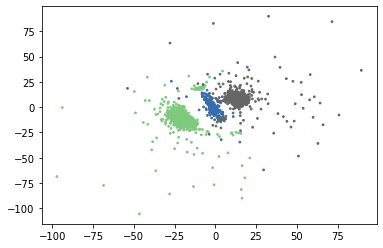

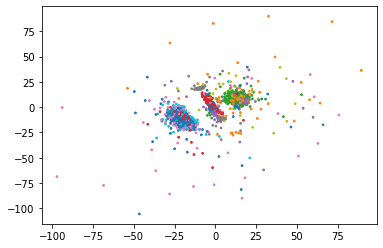

In [7]:
stress = mds.stress_
print(stress)

temp_reg = load_region(num=3)
plt.scatter(x2[:, 0], x2[:, 1], s=3, c=np.delete(temp_reg, clusters==5), cmap='Accent')  #region color mapping
plt.show();

plt.scatter(x2[:, 0], x2[:, 1], s=3, c=np.delete(clusters, clusters == 5), cmap='tab10')  #c=clusters for cluster color mapping
plt.show();


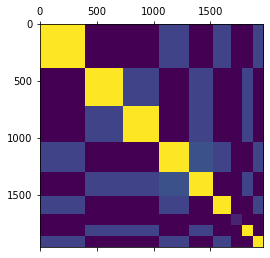

In [7]:
#cluster ordered weight matrix to show structure
tord = np.argsort(np.delete(clusters, clusters==5))
plt.matshow(new_weights_no5[:,tord][tord]);